## <a id='toc1_1_'></a>[Setup : chargement des données et des modèles](#toc0_)

In [12]:
import os


# Dataset batch size
BATCH_SIZE = 256
# Directory containing the dataset pickles
DATA_DIR = os.path.join("data", "pickle_img_datasets")
# Directory containing images
IMAGES_DIR = os.path.join("data", "images", "image_train")

In [13]:
from tensorflow import keras
import tensorflow as tf
import os
import pickle
from src.data import data


# Load data
X_train = pickle.load(
    open(os.path.join(DATA_DIR, "X_train.pkl"), "rb")).fillna("")
X_test = pickle.load(
    open(os.path.join(DATA_DIR, "X_test.pkl"), "rb")).fillna("")
y_test = pickle.load(open(os.path.join(DATA_DIR, "y_test.pkl"), "rb"))
y_train = pickle.load(open(os.path.join(DATA_DIR, "y_train.pkl"), "rb"))

# Extract the features to be ready for preprocessing
X_train_features = X_train['designation'] + " " + X_train['description']
X_test_features = X_test['designation'] + " " + X_test['description']

# Store the file path to images in variables
X_train_images = data.get_imgs_filenames(
    X_train["productid"], X_train["imageid"], IMAGES_DIR)
X_test_images = data.get_imgs_filenames(
    X_test["productid"], X_test["imageid"], IMAGES_DIR)

# Define DataFrame names for preprocessing
X_train_features.name = "X_train"
X_test_features.name = "X_test"

# Load text model
text_model = keras.models.load_model(
    os.path.join("data", "models", "mlp_text", "mlp_model_v2.1.h5"), compile=False)

# Load image model
image_model = keras.models.load_model(
    os.path.join("data", "models", "cnn_mobilenetv2_keras",
                 "cnn_mobilenetv2.h5"),
    compile=False)

# <a id='toc2_'></a>[Preprocessing du texte](#toc0_)

In [3]:
from src.data.text_preproc_pipeline import TextPreprocess
from src.data.vectorization_pipeline import TfidfStemming


# Data preprocessing
text_preprocessor = TextPreprocess(TfidfStemming())
text_preprocessor.fit(X_train_features)
X_test_preproc = text_preprocessor.transform(X_test_features)
X_train_preproc = text_preprocessor.transform(X_train_features)

INFO:textpipeline:class:TfidfStemming
INFO:textpipeline:TextPreprocess.fit X_train 158.31 seconds
INFO:textpipeline:TextPreprocess.transform X_test 36.67 seconds
INFO:textpipeline:TextPreprocess.transform X_train 213.52 seconds


# <a id='toc3_'></a>[Prédictions du modèle texte](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Setup : chargement des données et des modèles](#toc1_1_)    
- [Preprocessing du texte](#toc2_)    
- [Prédictions du modèle texte](#toc3_)    
- [Preprocessing des images](#toc4_)    
- [Prédictions du modèle image](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [10]:
from sklearn.metrics import accuracy_score
from src.data.data import convert_sparse_matrix_to_sparse_tensor, get_model_prediction


# Predict the categories of X_test
y_pred_text = text_model.predict(
    convert_sparse_matrix_to_sparse_tensor(X_test_preproc))

# Display the accuracy score
print("Text model accuracy score:", accuracy_score(
    y_test, get_model_prediction(y_pred_text)))

531/531 [==============================] - 2s 3ms/step
Text model accuracy score: 0.8086434291097504


# <a id='toc4_'></a>[Preprocessing des images](#toc0_)

In [16]:
from src.data.data import PRDTYPECODE_DIC, to_simplified_prdtypecode


def open_resize_img(filename: str, y) -> None:
    """
    Open image using the filename and return a resized version of it ready for the image model.

    Argument:
    - filename: complete path to image file including the extension.

    Return:
    - Image matrix in a tensor.
    """
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels=3)
    return (tf.image.resize(img, [224, 224]), y)


# Convert the prdtypecode to their equivalent in a range from 0 to 26
y_test_simplified = to_simplified_prdtypecode(y_test)
# Transforms y_test to a one hot version
y_test_categorical = tf.keras.utils.to_categorical(
    y_test_simplified, num_classes=len(PRDTYPECODE_DIC.keys()))

# Create the Dataset to feed the model with correctly sized images by batch
test_images_dataset = tf.data.Dataset.from_tensor_slices((X_test_images, y_test_categorical)) \
    .map(open_resize_img) \
    .batch(BATCH_SIZE)

# Convert the prdtypecode to their equivalent in a range from 0 to 26
y_train_simplified = to_simplified_prdtypecode(y_train)
# Transforms y_test to a one hot version
y_train_categorical = tf.keras.utils.to_categorical(
    y_train_simplified, num_classes=len(PRDTYPECODE_DIC.keys()))

# Create the Dataset to feed the model with correctly sized images by batch
train_images_dataset = tf.data.Dataset.from_tensor_slices((X_train_images, y_train_categorical)) \
    .map(open_resize_img) \
    .batch(BATCH_SIZE)

# <a id='toc5_'></a>[Prédictions du modèle image](#toc0_)

In [17]:
from sklearn.metrics import accuracy_score
from src.data.data import get_model_prediction


# Predict the categories of X_test
y_pred_image = image_model.predict(test_images_dataset)

# Display the accuracy score
print("Image model accuracy score:", accuracy_score(
    y_test, get_model_prediction(y_pred_image)))

67/67 [==============================] - 388s 6s/step
Image model accuracy score: 0.5444536033914272


# <a id='toc5_'></a>[Prédiction avant dernière couche du modèle texte](#toc0_)

In [6]:
from src.data.data import convert_sparse_matrix_to_sparse_tensor

# text model without head
text_model_wo_head = tf.keras.Model(
                            inputs=text_model.inputs,
                            outputs=text_model.layers[-2].output)

# Predict the output n-1 layer of X_test
test_text_layer = text_model_wo_head.predict(
     convert_sparse_matrix_to_sparse_tensor(X_test_preproc))
# Predict the output n-1 layer of X_train
train_text_layer = text_model_wo_head.predict(
     convert_sparse_matrix_to_sparse_tensor(X_train_preproc))


2123/2123 [==============================] - 5s 2ms/step


# <a id='toc5_'></a>[Prédiction avant dernière couche du modèle image](#toc0_)

In [7]:
# image model without head
image_model_wo_head = tf.keras.Model(inputs=image_model.inputs,
                           outputs=image_model.layers[-2].output)

# Predict the output n-1 layer with X_test
test_image_output = image_model_wo_head.predict(test_images_dataset)

# Predict the output n-1 layer with X_train
train_image_output = image_model_wo_head.predict(train_images_dataset)



266/266 [==============================] - 1537s 6s/step


# <a id='toc5_'></a>[Concatenation des données](#toc0_)

In [6]:
import numpy as np

# Text/Image train concatenation 
train_concat_layer = np.concatenate((train_text_layer, train_image_output), axis=1)

filename = os.path.join(DATA_DIR, r'fusion_train_data.pkl')
with open(filename, 'wb') as fp:
    pickle.dump(train_concat_layer, fp)

# Text/Image train concatenation 
test_concat_layer = np.concatenate((test_text_layer, test_image_output), axis=1)

filename = os.path.join(DATA_DIR, r'fusion_test_data.pkl')
with open(filename, 'wb') as fp:
    pickle.dump(test_concat_layer, fp)


NameError: name 'train_text_layer' is not defined

In [14]:
# Load saved pickle
filename = os.path.join(DATA_DIR, r'fusion_train_data.pkl')
train_concat_layer =  pickle.load(open(filename , "rb"))
filename = os.path.join(DATA_DIR, r'fusion_test_data.pkl')
test_concat_layer =  pickle.load(open(filename , "rb"))

In [17]:
# Create dataset
train_fusion_dataset = tf.data.Dataset.from_tensor_slices((train_concat_layer, y_train_categorical)).batch(BATCH_SIZE)
test_fusion_dataset = tf.data.Dataset.from_tensor_slices((test_concat_layer, y_test_categorical)).batch(BATCH_SIZE)

# <a id='toc5_'></a>[Model Fusion definition](#toc0_)

In [18]:
from tensorflow.keras import layers

# Input/Output dimensions 
INPUT_FUSION_SIZE = train_concat_layer.shape[1]
NB_OF_OUTPUT_CLASSES = 27

fusion_model = tf.keras.Sequential()
fusion_model.add(layers.InputLayer(input_shape=(INPUT_FUSION_SIZE)))
fusion_model.add(layers.Dense(units=512, activation='relu'))
fusion_model.add(layers.Dropout(rate=0.2))

fusion_model.add(layers.Dense(units=128, activation='relu'))
fusion_model.add(layers.Dropout(rate=0.2))

fusion_model.add(layers.Dense(NB_OF_OUTPUT_CLASSES, 
                       activation='softmax',
                       name="Output"))

In [5]:
import datetime

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.train import latest_checkpoint


# Checkpoint directory and paths
CHECKPOINT_DIR = os.path.join(
    "data", "models", "fusion_text_image_keras")
CHECKPOINT_PATH = os.path.join(
    CHECKPOINT_DIR, "cp_{val_loss:.2f}-{val_accuracy:.2f}-.ckpt")

# Path to the history CSV file to store training metrics
HIST_CSV_PATH = os.path.join(CHECKPOINT_DIR, "history.csv")

# Define where to store training logs
LOG_DIR = os.path.join(CHECKPOINT_DIR, "logs", "fit")
LOG_DATA = os.path.join(
    LOG_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [8]:
# Training
fusion_model.build((None, INPUT_FUSION_SIZE))
fusion_model.compile(
    optimizer=SGD(learning_rate=0.005, momentum=0.9),
    loss=CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy'])

latest = latest_checkpoint(CHECKPOINT_DIR)
if (latest is not None):
    print("Loading checkpoint", latest)
    fusion_model.load_weights(latest)
else:
    print("No checkpoint to load")

# Callbacks called between each epoch
cp_callbacks = [
    # Stop the training when there is no improvement in val_accuracy for x epochs
    EarlyStopping(monitor='val_accuracy', patience=3),   #patience=10),
    # Save a checkpoint
    ModelCheckpoint(CHECKPOINT_PATH,
                    save_best_only=True,
                    mode="max",
                    monitor="val_accuracy",
                    save_weights_only=True,
                    verbose=1),
    # Insert the metrics into a CSV file
    CSVLogger(HIST_CSV_PATH, separator=',', append=True),
    # Log information to display them in TensorBoard
    TensorBoard(log_dir=LOG_DIR, histogram_freq=1)
]

fusion_model.fit(
    train_fusion_dataset,
    epochs=100,
    validation_data=test_fusion_dataset,
    callbacks=cp_callbacks)

No checkpoint to load
Epoch 1/100


d:\Agnoli\Datascientest\Projet\Fev23_BDS_Rakuten\.conda\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


263/266 [============================>.] - ETA: 0s - loss: 2.1004 - accuracy: 0.4965
Epoch 1: val_accuracy improved from -inf to 0.63472, saving model to data\models\fusion_text_image_keras\cp_1.65-0.63-.ckpt
266/266 [==============================] - 8s 23ms/step - loss: 2.0967 - accuracy: 0.4976 - val_loss: 1.6525 - val_accuracy: 0.6347
Epoch 2/100
264/266 [============================>.] - ETA: 0s - loss: 1.5255 - accuracy: 0.6891
Epoch 2: val_accuracy improved from 0.63472 to 0.71556, saving model to data\models\fusion_text_image_keras\cp_1.44-0.72-.ckpt
266/266 [==============================] - 5s 20ms/step - loss: 1.5249 - accuracy: 0.6893 - val_loss: 1.4396 - val_accuracy: 0.7156
Epoch 3/100
263/266 [============================>.] - ETA: 0s - loss: 1.3142 - accuracy: 0.7713
Epoch 3: val_accuracy improved from 0.71556 to 0.75972, saving model to data\models\fusion_text_image_keras\cp_1.32-0.76-.ckpt
266/266 [==============================] - 6s 21ms/step - loss: 1.3132 - accura

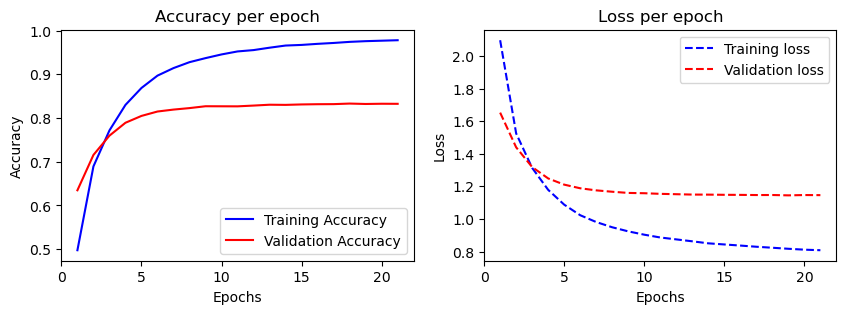

In [8]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

training_history = pd.read_csv(HIST_CSV_PATH, delimiter=",", header=0)


fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(121)

# Labels des axes
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
ax1.plot(np.arange(1, training_history["accuracy"].count() + 1, 1),
         training_history["accuracy"],
         label='Training Accuracy',
         color='blue')

# Courbe de la précision sur l'échantillon de test
ax1.plot(np.arange(1, training_history["val_accuracy"].count() + 1, 1),
         training_history['val_accuracy'],
         label='Validation Accuracy',
         color='red')

ax1.legend()
ax1.set_title("Accuracy per epoch")
ax2 = fig.add_subplot(122)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

ax2.plot(np.arange(1, training_history["loss"].count() + 1, 1),
         training_history['loss'],
         label='Training loss',
         linestyle="dashed",
         color='blue')

ax2.plot(np.arange(1, training_history["val_loss"].count() + 1, 1),
         training_history['val_loss'],
         label='Validation loss',
         linestyle="dashed",
         color='red')

ax2.legend()
ax2.set_title("Loss per epoch")

# Affichage de la figure
plt.show()

# <a id='toc4_'></a>[Prédiction du modèle de fusion](#toc0_)

In [25]:
from sklearn.metrics import accuracy_score
from src.data.data import get_model_prediction

fusion_model.load_weights(r'D:/Agnoli/Datascientest/Projet/Fev23_BDS_Rakuten/data/models/fusion_text_image_keras/cp_1.15-0.83-.ckpt')


# Predict the categories of X_test
y_pred_image = fusion_model.predict(test_fusion_dataset)

# Display the accuracy score
print("Image model accuracy score:", accuracy_score(
    y_test, get_model_prediction(y_pred_image)))

67/67 [==============================] - 1s 10ms/step
Image model accuracy score: 0.8331370701837023


# <a id='toc4_'></a>[Affichage du rapport de classification](#toc0_)

In [26]:
from sklearn import metrics

print(metrics.classification_report(y_test, get_model_prediction(y_pred_image)))


              precision    recall  f1-score   support

          10       0.68      0.58      0.63       570
          40       0.77      0.80      0.78       508
          50       0.79      0.84      0.81       335
          60       0.95      0.88      0.91       179
        1140       0.78      0.85      0.81       536
        1160       0.96      0.98      0.97       786
        1180       0.78      0.62      0.69       165
        1280       0.68      0.64      0.66       958
        1281       0.62      0.50      0.55       411
        1300       0.89      0.93      0.91      1044
        1301       0.95      0.94      0.95       157
        1302       0.85      0.79      0.82       499
        1320       0.87      0.77      0.82       694
        1560       0.78      0.82      0.80      1030
        1920       0.90      0.92      0.91       889
        1940       0.86      0.86      0.86       167
        2060       0.79      0.77      0.78      1022
        2220       0.91    

# <a id='toc4_'></a>[Affichage de la matrice de confusion](#toc0_)

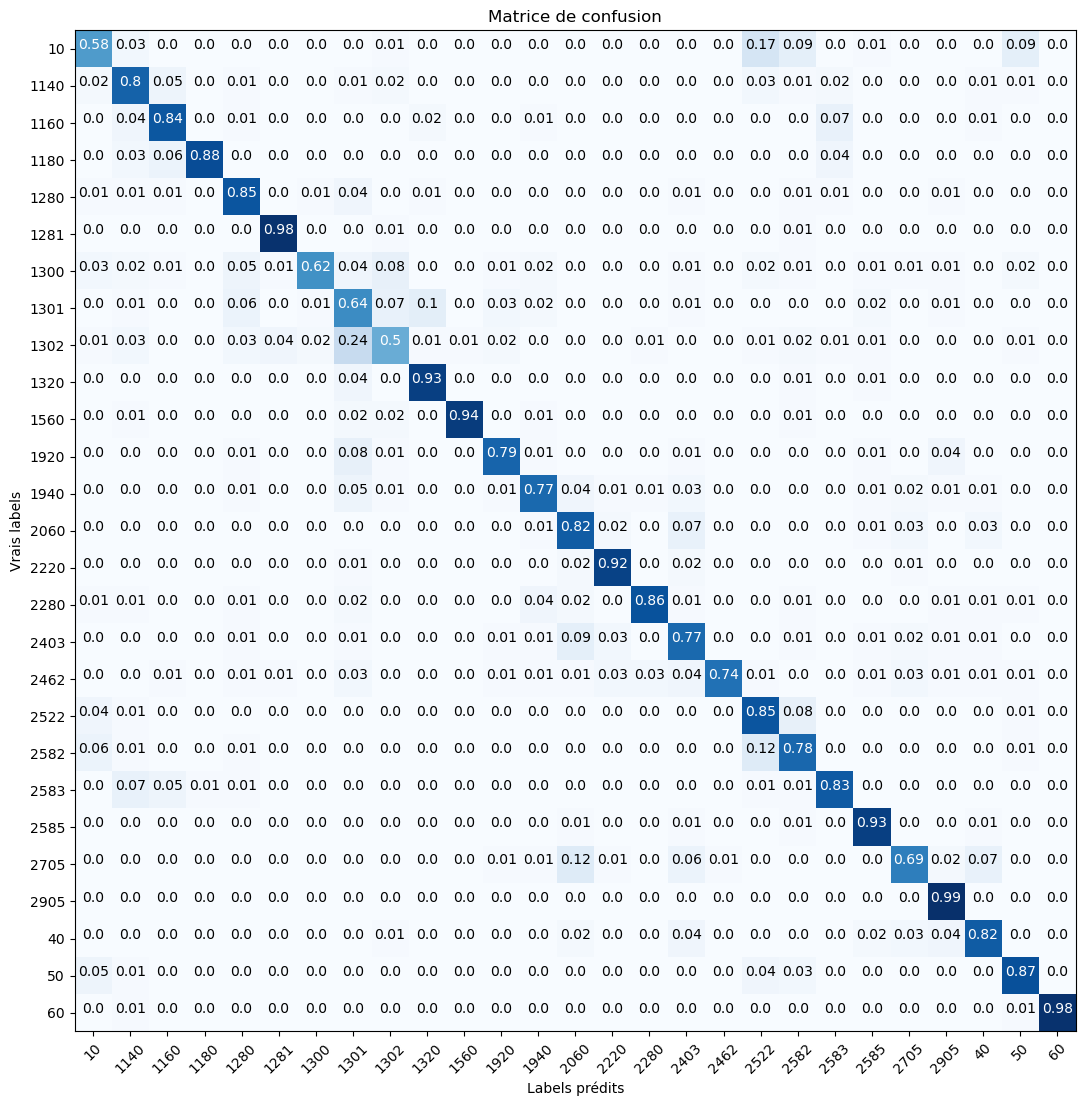

In [27]:
import itertools
from matplotlib import pyplot as plt

from src.data.data import PRDTYPECODE_DIC

NB_OF_OUTPUT_CLASSES = 27

cnf_matrix = np.round(metrics.confusion_matrix(
    y_test, get_model_prediction(y_pred_image), normalize="true"), 2)

classes = range(0, NB_OF_OUTPUT_CLASSES)

plt.figure(figsize=(13, 13))

plt.imshow(cnf_matrix, interpolation='nearest', cmap='Blues')
plt.title("Matrice de confusion")
tick_marks = classes
plt.xticks(tick_marks, PRDTYPECODE_DIC.keys())
plt.yticks(tick_marks, PRDTYPECODE_DIC.keys())

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > (cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.xticks(rotation=45)
plt.show()